# Visualizing Embedding Spaces

Embeddings are high-dimensional representations of our data. While they are useful for various AI applications, they can be hard to reason about. Projecting these high-dimensional objects onto a 2D space, allows us to visualize them, identify clusters, highlight anomalies, and more generally assess the quality of our data.

In this notebook, we will see how visualizing an embeddings space can help us reason about our data and identify pitfalls in a RAG pipeline. We will use a dataset of customer support messages from Chroma Cloud. One possible application of such dataset is building a customer support agent. Each user query can map to a good answer, and when a new query comes in, the agent can look up this dataset to compile its answer.

## Setup

1. [Log in](https://trychroma.com/login) to your Chroma Cloud account. If you are a first time user, you can [sign up](https://trychroma.com/signup) to get your own account. You will get free credits that are more than enough to run this notebook.
2. Create a new Database, and name it `visualizations`, or any name of your choice.
3. Choose the "Load a sample dataset" option, and then the "Customer support messages" dataset. This will copy the dataset into a collection in your new Chroma Database.
4. In the "Settings" tab, scroll down and choose the `.env` option. Click on the "Create API key" button, and copy the connection environment variables.
5. Create a new `.env` file in this directory (`chroma-cookbooks/embeddings-visualizer`) and paste your environment variables.
6. You will also need an OpenAI [API key](https://platform.openai.com/api-keys). Set it in your `.env` file under `OPENAI_API_KEY`.
7. Load the keys in this notebook

In [121]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key=os.getenv("CHROMA_API_KEY")
tenant=os.getenv("CHROMA_TENANT")
database=os.getenv("CHROMA_DATABASE")
openai_key=os.getenv("OPENAI_API_KEY")

## Explore the Dataset

Let's get the dataset into this notebook. In our `get` call, we include the embeddings in this collection so we can use them for our visualizations later on.

In [122]:
import chromadb
import pandas as pd
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

client = chromadb.CloudClient(
    api_key=api_key,
    tenant=tenant,
    database=database
)

# We will reuse this later on
embedding_function = OpenAIEmbeddingFunction(
    api_key=openai_key, 
    model_name="text-embedding-3-large"
)

collection = client.get_collection(
    "customer-support-messages",
    embedding_function=embedding_function
)

records = collection.get(include=["documents", "metadatas", "embeddings"])

data = [
    {"id": record_id, "document": records["documents"][i], "from": records["metadatas"][i]["from_email"]}
    for i, record_id in enumerate(records["ids"])
]

df = pd.DataFrame(data)
df.head()

,id,document,from
0,e8789e2b-3dbe-4c9f-a4de-2396ce4d1bb3,I accidentally deleted several project boards ...,troy.pfeffer18@example.com
1,351c6689-2560-443e-9647-ce9787f5eaae,"Since updating the mobile app yesterday, it cr...",otto_osinski17@example.com
2,13b7b05b-eb3f-4cd7-858f-5df0de30386f,I just realized that collaborators in my team ...,pearlie.langworth64@example.com
3,98d6cc10-f1e1-493b-aa4e-ba1cf7c29846,I’m trying to export all our project boards to...,vance_ledner@example.com
4,996519b9-3e58-4b78-9911-b1e95de8b6e5,I upgraded to the Pro plan of TaskForge yester...,sage.williamson@example.com


We can see that the first few records contain customer questions about a product. Each record has the `from_email` metadata field indicating the user email of the inquirer.

## Visualizing our Embedding Space

We will project our embeddings onto a 2-dimensional space using `umap`; it is similar to PCA in the sense that it is a dimensionality reduction technique, but `umap` tries to preserve the distances between points as much as possible from the original vector space, whereas PCA tries to find the dominant directions onto which the data is then projected.

Here, we fit a `umap` transformer to the embeddings associated with each customer support query. We set the random states so we can get reproducable results.

_Note_: You might get a warning about the random state being set. This is intentional so the results of this notebook remain consistent across runs

In [123]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = records["embeddings"]

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/itaismith/Developer/chroma-cookbooks/embeddings-visualizer/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Now that we have a `umap` transformer, we can write a function that will project embeddings into a 2-dimensional space:

In [124]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings 

We will use `matplotlib` to visualize our projected embeddings in a scatterplot:

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 618.05it/s]


(np.float64(-6.513811683654785),
 np.float64(17.91141757965088),
 np.float64(-6.976258444786072),
 np.float64(14.565848994255067))

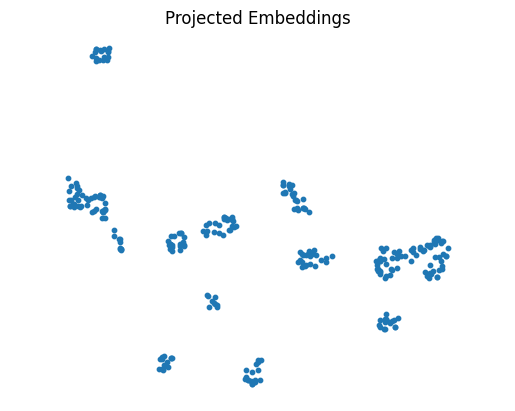

In [125]:
import matplotlib.pyplot as plt

projected_dataset_embeddings = project_embeddings(
  embeddings, umap_transform
)

plt.figure()

plt.scatter(
  projected_dataset_embeddings[:, 0], 
  projected_dataset_embeddings[:, 1],
  s=10
)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

We can see that our records cluster nicely into clusters. This suggests that there are groups of records that cover similar topics or ideas. They are semantically similar, so they appear close together in the embedding space. We can already see that some clusters are larger than others. Suggesting that this dataset has good cover for some customer questions but not others.

## Using Visualizations for Data Analysis

To start analyzing our dataset, we can submit some queries and visualize them on the same space. Let's query for **questions about account deletion**, and see what records we get back

In [126]:
account_deletion_query = "questions about account deletion"

account_deletion_records = collection.query(
    query_texts=[account_deletion_query], 
    include=["documents", "embeddings"],
    n_results=5
)

for doc in account_deletion_records["documents"][0]:
    print(f"{doc}\n")

I’m trying to downgrade from the Pro plan and completely cancel my subscription before the next renewal, but the Cancel button in the billing settings is greyed out. Could you walk me through the exact steps to terminate the account and confirm whether my stored projects will be deleted or just archived?

I need to cancel my Pro subscription before it renews next week, but the cancel button in my account settings is greyed out. If I delete my workspace, will that automatically stop the subscription, and will I still have read-only access to my notes afterward?

I’m trying to cancel my subscription before the next billing date, but I can’t find the option in the account settings. Is there a specific place to request cancellation and will I still have access to my projects until the end of the current cycle?

I’m trying to cancel my Team Plus subscription, but the billing page only shows options to upgrade or pause the plan. If I complete the cancellation, will my projects be deleted rig

### Plotting Queries

Let's visualize this query and the results in our embedding space. We will create a function that produces the plot of our embedding space, sets the query to be a red X, and the results of the query as empty green circles:

In [127]:
from chromadb import QueryResult

def plot_query(query: str, records: QueryResult) -> None:
    query_embedding = embedding_function([query])[0]
    
    retrieved_embeddings = records['embeddings'][0]
    
    projected_query_embedding = project_embeddings(
        [query_embedding], umap_transform
    )
    
    projected_retrieved_embeddings = project_embeddings(
        retrieved_embeddings,
        umap_transform
    )

    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(
      projected_dataset_embeddings[:, 0], 
      projected_dataset_embeddings[:, 1], 
      s=10, color='gray'
    )
    
    plt.scatter(
      projected_query_embedding[:, 0], 
      projected_query_embedding[:, 1], 
      s=150, marker='X', color='r'
    )
    
    plt.scatter(
      projected_retrieved_embeddings[:, 0], 
      projected_retrieved_embeddings[:, 1], 
      s=100, facecolors='none', edgecolors='g'
    )
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 218.20it/s]


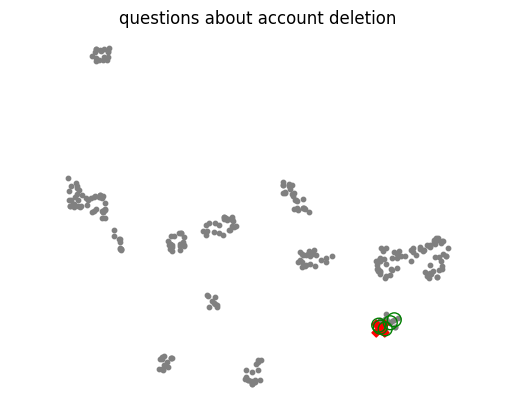

In [128]:
plot_query(account_deletion_query, account_deletion_records)

By the records and the visualization, we can see that one of our clusters is clearly about subscription cancellation. This also suggests that the retrieval for queries about cancellation are "tight". Our dataset has good cover for this topic.

We can also try a very general query like **I need help with something**:

I clicked “Forgot Password” and got the email, but the link opens a blank page instead of the reset form. I’m locked out of my account with a project deadline in a few hours—can you help me get a new password?

I requested a password reset yesterday, but the email link never showed up in my inbox or spam folder. Can you help me regain access to my workspace so I don’t lose the tasks and notes I have due today?

I’m on the free tier of your productivity suite and need to upgrade to the Team Pro plan, but I’m worried about how the change will affect my existing projects and shared workspaces. Can you walk me through the upgrade steps and confirm whether I can roll back or adjust seats later if our budget changes?

I clicked “Forgot Password” twice today, but the reset email never shows up in my inbox or spam folder. Can you help me get a new link so I can log back in and finish syncing my project boards?

I’m trying to switch from the free tier to the Pro plan so I can unlock the automat

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 223.95it/s]


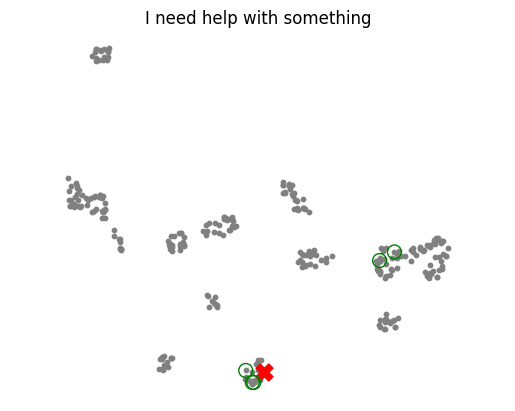

In [129]:
general_query = "I need help with something"

general_query_records = collection.query(
    query_texts=[general_query], 
    include=["documents", "embeddings"],
    n_results=5
)

for doc in general_query_records["documents"][0]:
    print(f"{doc}\n")

plot_query(general_query, general_query_records)

We can see that the results are spread across the embedding space, and a simple retrieval pass for such query will not give an LLM enough information. In such cases, we often need to resort to more sophisticated methods like agentic search, asking for user clarification, etc. 

### Idenitfying Gaps

Visualizing the space is also helpful for identifying gaps in our data. For example, when we issue the query **is your platform GDPR compliant**:

I’m integrating your platform into our internal dashboard and the public API docs still reference v2 endpoints, but the sandbox only returns responses for v3. Could you clarify where I can find the updated schema and examples for creating recurring tasks via v3, and whether the OAuth scopes have changed?

I’m integrating our internal dashboard with your productivity platform, but the API documentation still references the deprecated v1 endpoints and glosses over how OAuth refresh tokens are handled. Can you provide updated guidance on token refresh flow and confirm whether the new v2 endpoints support the same rate limits?

I’m trying to connect your platform with our Jira instance, but the webhook keeps failing and I’m not seeing any detailed error logs. Can you walk me through the correct authentication steps and any required permissions so our existing projects will sync properly?

Your platform automatically renewed my Pro subscription yesterday even though I disabled auto-renew we

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 244.61it/s]


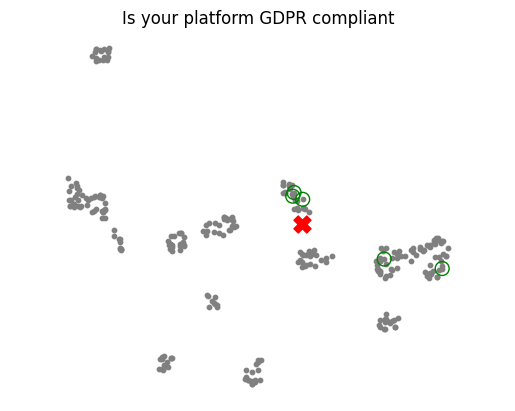

In [130]:
gdpr_query = "Is your platform GDPR compliant"

gdpr_query_records = collection.query(
    query_texts=[gdpr_query], 
    include=["documents", "embeddings"],
    n_results=5
)

for doc in gdpr_query_records["documents"][0]:
    print(f"{doc}\n")

plot_query(gdpr_query, gdpr_query_records)

Here we can see that not only the results are irrelevant and scattered across the space, the query itself lands in an empty region in the space. This means that we don't have coverage for queries of this kind.

### Identifying Clusters

The visualization can help us identify the clusters in our data. We can see that there are roughly 12 clusters in this space. Let's use `scikit-learn` to find them:

In [131]:
from sklearn.cluster import KMeans

# Cluster the projected 2D embeddings
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projected_dataset_embeddings)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Next, we can take each embedding from our projected space and match it to the document from our dataset it represents. Then, since we have the clusters figured out, we can take a sample of 5 documents from each cluster, and let an LLM produce a category label for each cluster.

In [132]:
from openai import OpenAI

# Get cluster labels from LLM
openai_client = OpenAI(api_key=openai_key)
documents = records["documents"]
cluster_names = []

for cluster_id in range(n_clusters):
    cluster_docs = [doc for i, doc in enumerate(documents) if labels[i] == cluster_id][:5]
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[{
            "role": "user",
            "content": f"Give a 2-3 word category name for these customer support messages. The category name should be as specific as possible like billing, docs, etc. Reply with ONLY the category name.\n\n{cluster_docs}"
        }]
    )
    cluster_names.append(response.choices[0].message.content.strip())

Finally, we can visualize the space with the labeled clusters:

(np.float64(-6.513811683654785),
 np.float64(17.91141757965088),
 np.float64(-6.976258444786072),
 np.float64(14.565848994255067))

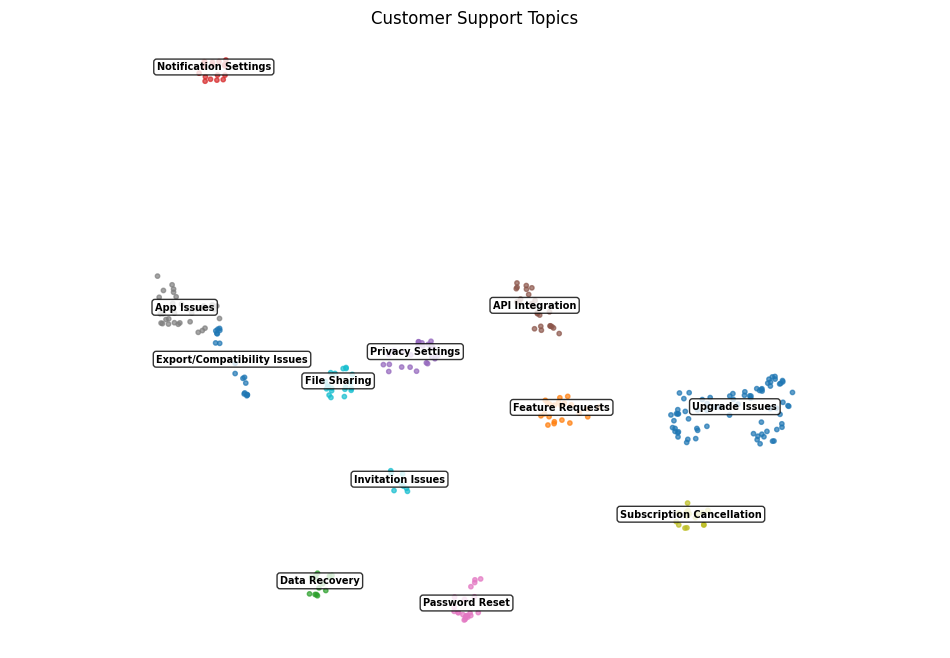

In [133]:
# Plot with labels
plt.figure(figsize=(12, 8))

# Scatter points colored by cluster
plt.scatter(
  projected_dataset_embeddings[:, 0],
  projected_dataset_embeddings[:, 1],
  c=labels,
  cmap='tab10',
  s=10,
  alpha=0.7
)

# Add labels at centroids
for i, (centroid, name) in enumerate(zip(centroids, cluster_names)):
  plt.annotate(
      name,
      centroid,
      fontsize=7,
      fontweight='bold',
      ha='center',
      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
  )

plt.gca().set_aspect('equal', 'datalim')
plt.title('Customer Support Topics')
plt.axis('off')